# Quadratic function

In [1]:
# Using models from Jupyter Lab
import numpy as np
from scipy.optimize import fmin_cobyla
from matplotlib import pylab as plt

import optimizers
from importlib import reload

In [2]:
def f(x, args):
    np.random.seed(args['seed'])
    xi = args['sigma'] * np.random.standard_normal(1)
    return 1./2 * x.T @ args['A'] @ x + xi

def gradient_true(x, args):
    return args['A'] @ x

args = {}
args['d'] = 10
args['mu'] = 1
args['L'] = 1000
args['func'] = f
args['seed'] = 18181818

args['A'] = optimizers.generate_A(args['d'], args['mu'], args['L'], args['seed'])

np.random.seed(args['seed'])
w_0 = np.random.random_sample(args['d'])
w_0 = np.abs(w_0) / np.linalg.norm(w_0, ord = 1)

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / args['L']

def momentum_k(k, f, nabla_f, x_k, args):
    return k / (k + 1)

In [3]:
def graph(args, optimizer, R_0, label, title):
    
    errors_full = []
    iterations_full = []
    labels_full = []
    
    for norm in args['norms']:
        args['norm'] = norm

        w_sol, errors, _ = optimizer.search()
        is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                           and (np.linalg.norm(w_sol, ord=1) == 1))
        iterations = range(1, len(errors)+1)
        errors_full.append(errors / R_0)
        iterations_full.append(iterations)
        labels_full.append(label + " norm = %i" % norm)
        print(label + " norm=%i. f(w_sol) = %.5f \
                , w_sol in simplex: %s, sum: %.5f" % (norm, f(w_sol, args), is_in_simplex, sum(w_sol)))

    y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'
    optimizers.make_err_plot(iterations_full, errors_full,
                         labels=labels_full, title=title, markers=[None]*100)
    return errors_full, iterations_full, labels_full, w_sol

In [4]:
args['sigma'] = 1
args['eps'] = 1e-6

In [26]:
reload(optimizers)

args['gamma'] = lambda k: 1 / np.sqrt(k)
args['max_steps'] = 10 ** 4
args['criterium'] = 'f(x_k) - f(x^*)'
args['x_sol'] = np.zeros(args['d'])

args['batch_size'] = 1
args['momentum_k'] = momentum_k
args['proj'] = False
args['norms'] = [2]
args['x_sol'], _ , _ = optimizers.MDOptimizer(f, gradient_true, x_0 = w_0, step = const_gamma, args = args).search()

In [27]:
w_sol_true = args['x_sol']
print(f(w_sol_true, args))

[9.76460351]


In [28]:
R_0 = f(w_0, args) - f(w_sol_true, args)

# TWO POINT FEEDBACK

## Mirror descent

MD, TPF norm=2. f(w_sol) = 9.78951                 , w_sol in simplex: True, sum: 1.00000


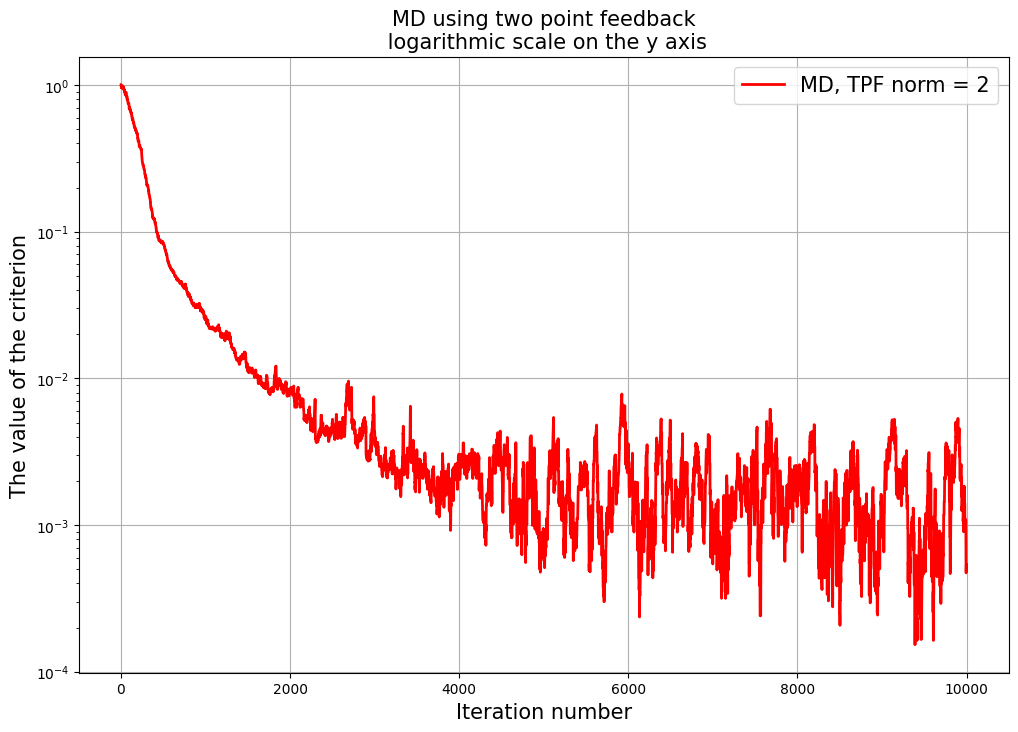

In [44]:
reload(optimizers)

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / args['L']

title = "MD using two point feedback"
label = 'MD, TPF'

args['gamma'] = lambda k: 1 / np.sqrt(k)
args['max_steps'] = 10 ** 4
args['criterium'] = 'f(x_k) - f(x^*)'

args['batch_size'] = 1
args['momentum_k'] = momentum_k
args['proj'] = False
args['norms'] = [2]

optimizer = optimizers.MDOptimizer(f, optimizers.get_grad_tpf_v3, x_0 = w_0, step = const_gamma, args = args)

iterations_mir_tpf, errors_mir_tpf, labels_mir_tpf, _ = graph(args, optimizer, R_0, label, title)

## Momentum based FW

MBFW, TPF, norm=2. f(w_sol) = 25.32947                 , w_sol in simplex: False, sum: 1.00000


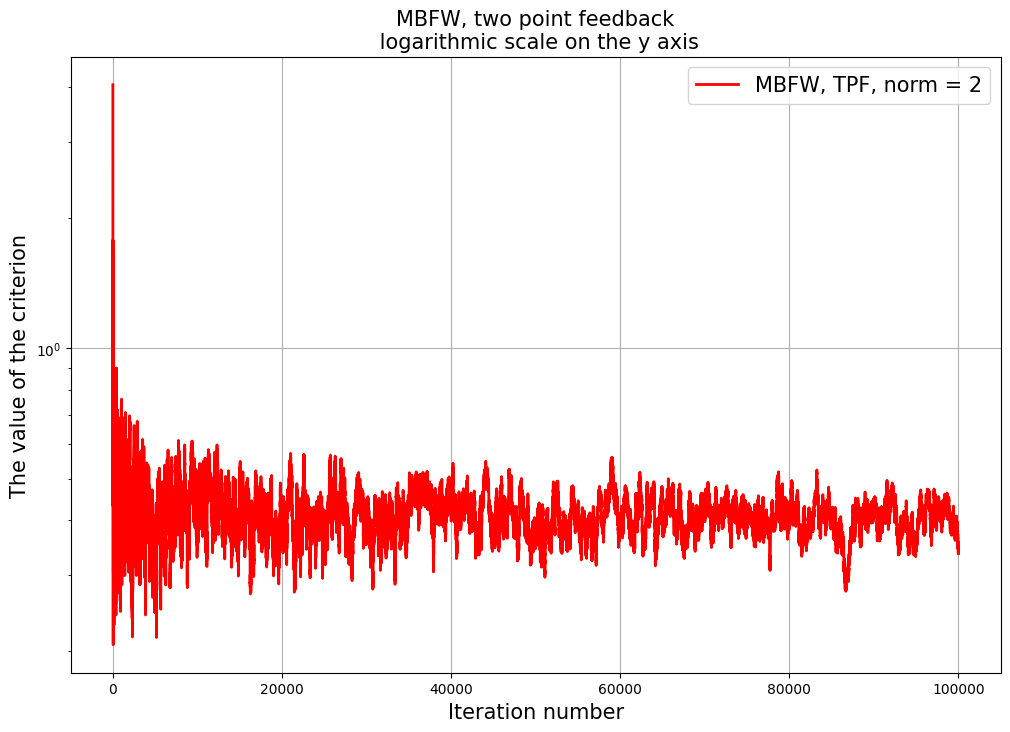

In [52]:
reload(optimizers)

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / ((k + 1) * args['L'])

title = "MBFW, two point feedback"
label = 'MBFW, TPF,'

args['gamma'] = lambda k: 1 / np.sqrt(k)
args['max_steps'] = 10 ** 5
args['criterium'] = 'f(x_k) - f(x^*)'

args['batch_size'] = 1
args['momentum_k'] = momentum_k
args['proj'] = False
args['norms'] = [2]

optimizer = optimizers.MBFWOptimizer(f, optimizers.get_grad_tpf_v3, x_0 = w_0, step = const_gamma, args = args)

iterations_mbfw_tpf, errors_mbfw_tpf, labels_mbfw_tpf, _ = graph(args, optimizer, R_0, label, title)

## Frank Wolfe

FW, TPF, norm=2. f(w_sol) = 149.21810                 , w_sol in simplex: True, sum: 1.00000


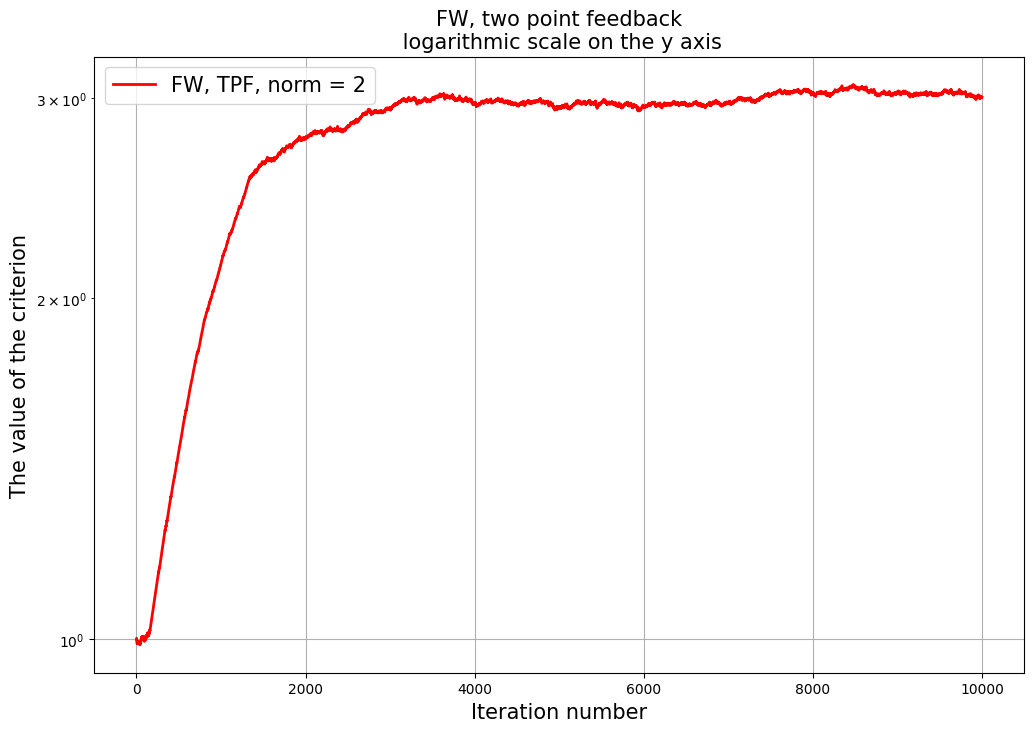

In [60]:
reload(optimizers)

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (1 * args['L'])

title = "FW, two point feedback"
label = 'FW, TPF,'

args['gamma'] = lambda k: 1 / np.sqrt(k)
args['max_steps'] = 10 ** 4
args['criterium'] = 'f(x_k) - f(x^*)'

args['batch_size'] = 2
args['momentum_k'] = momentum_k
args['proj'] = False
args['norms'] = [2]

optimizer = optimizers.FWOptimizer(f, optimizers.get_grad_tpf_v3, x_0 = w_0, step = const_gamma, args = args)

iterations_fw_tpf, errors_fw_tpf, labels_fw_tpf, _ = graph(args, optimizer, R_0, label, title)

## Projection

Projection, TPF, norm=1. f(w_sol) = 9.79632                 , w_sol in simplex: True, sum: 1.00000


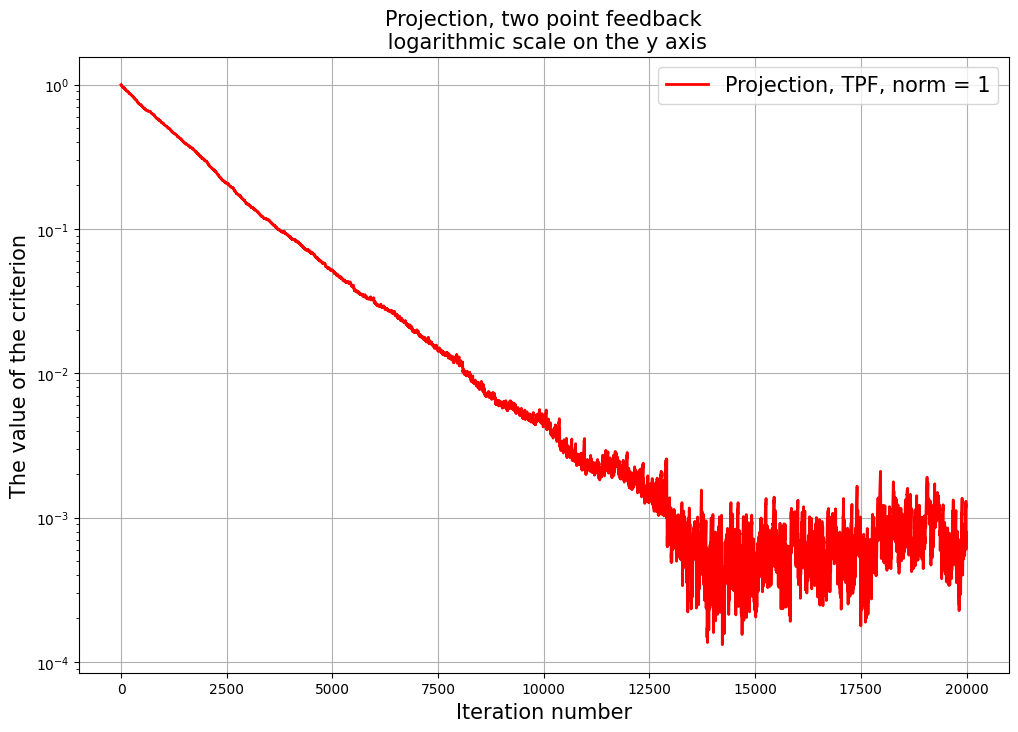

In [62]:
reload(optimizers)

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (100 * args['L'])

title = "Projection, two point feedback"
label = 'Projection, TPF,'

args['gamma'] = lambda k: 1 / np.sqrt(k)
args['max_steps'] = 2 * 10 ** 4
args['criterium'] = 'f(x_k) - f(x^*)'

args['batch_size'] = 1
args['momentum_k'] = momentum_k
args['proj'] = True
args['norms'] = [1]

optimizer = optimizers.GDOptimizer(f, optimizers.get_grad_tpf_v3, x_0 = w_0, step = const_gamma, args = args)

iterations_pr_tpf_v3, errors_pr_tpf_v3, labels_pr_tpf_v3, _ = graph(args, optimizer, R_0, label, title)

Projection, TPF, norm=1. f(w_sol) = 9.87488                 , w_sol in simplex: True, sum: 1.00000


Projection, TPF, norm=2. f(w_sol) = 10.19770                 , w_sol in simplex: True, sum: 1.00000


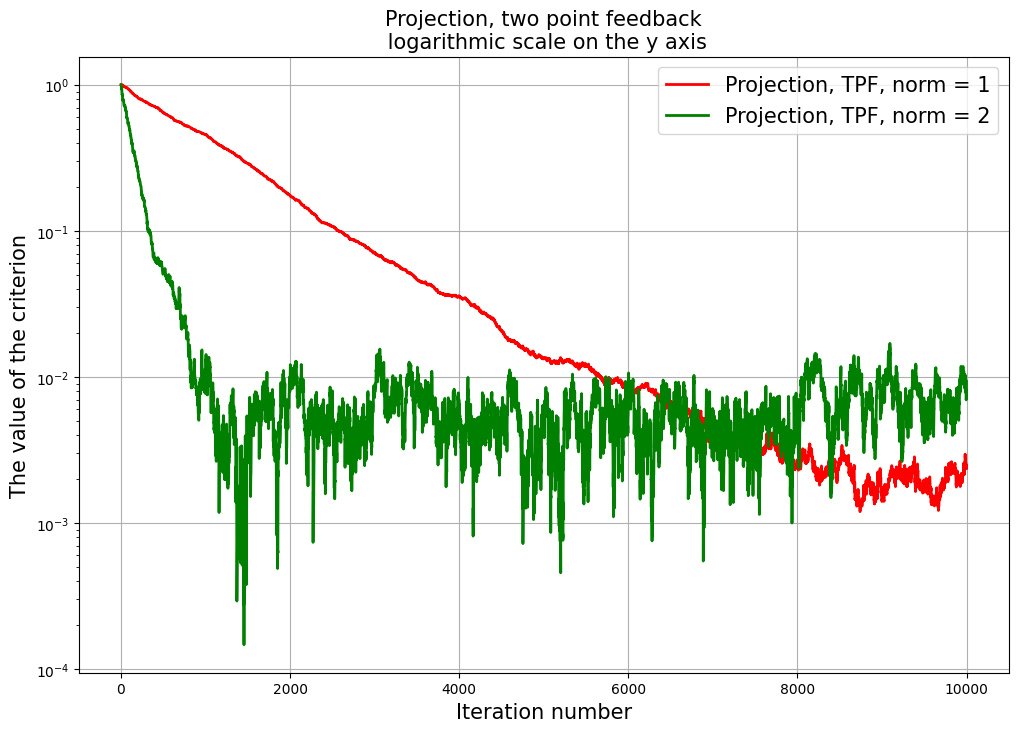

In [64]:
reload(optimizers)

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (10 * args['L'])

title = "Projection, two point feedback"
label = 'Projection, TPF,'

args['gamma'] = lambda k: 1 / np.sqrt(k)
args['max_steps'] = 10 ** 4
args['criterium'] = 'f(x_k) - f(x^*)'

args['batch_size'] = 1
args['momentum_k'] = momentum_k
args['proj'] = True
args['norms'] = [1, 2]

optimizer = optimizers.GDOptimizer(f, optimizers.get_grad_tpf, x_0 = w_0, step = const_gamma, args = args)

iterations_pr_tpf, errors_pr_tpf, labels_pr_tpf, _ = graph(args, optimizer, R_0, label, title)

## COBYLA

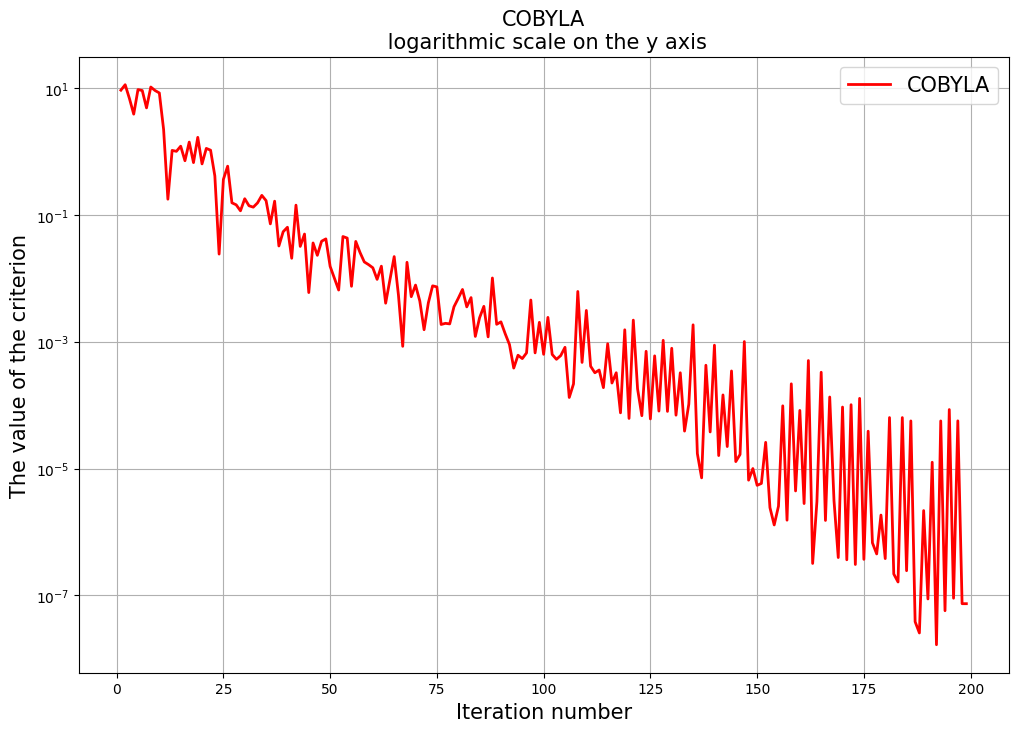

FW, TPF, norm=2. f(w_sol) = 9.76461        , w_sol in simplex: False, sum: 1.00000


In [65]:
constraints = [lambda x: 1 - sum(x), lambda x: sum(x) - 1, lambda x: x]

A = args['A']
seed = args['seed']
def f(x, *args):
    np.random.seed(seed)
    xi = 1 * np.random.standard_normal(1)
    return 1./2 * x.T @ A @ x + xi

errors_cobyla = []
def callback_func(x):
    errors_cobyla.append((float(f(x)) - f(w_sol_true))/R_0)
        
w_sol = fmin_cobyla(func = f, x0 = w_0, cons=constraints, catol=0.,
                    rhoend=1e-4, maxfun=2000, callback=callback_func)
is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                       and (np.linalg.norm(w_sol, ord=1) == 1))
iterations_cobyla = range(1, len(errors_cobyla)+1)

title = "COBYLA"
optimizers.make_err_plot([iterations_cobyla], [np.abs(errors_cobyla)],
                     labels=["COBYLA"], title=title, markers=[None]*100)
print("FW, TPF, norm=%i. f(w_sol) = %.5f \
       , w_sol in simplex: %s, sum: %.5f" % (2, f(w_sol, args), is_in_simplex, sum(w_sol)))

## Results

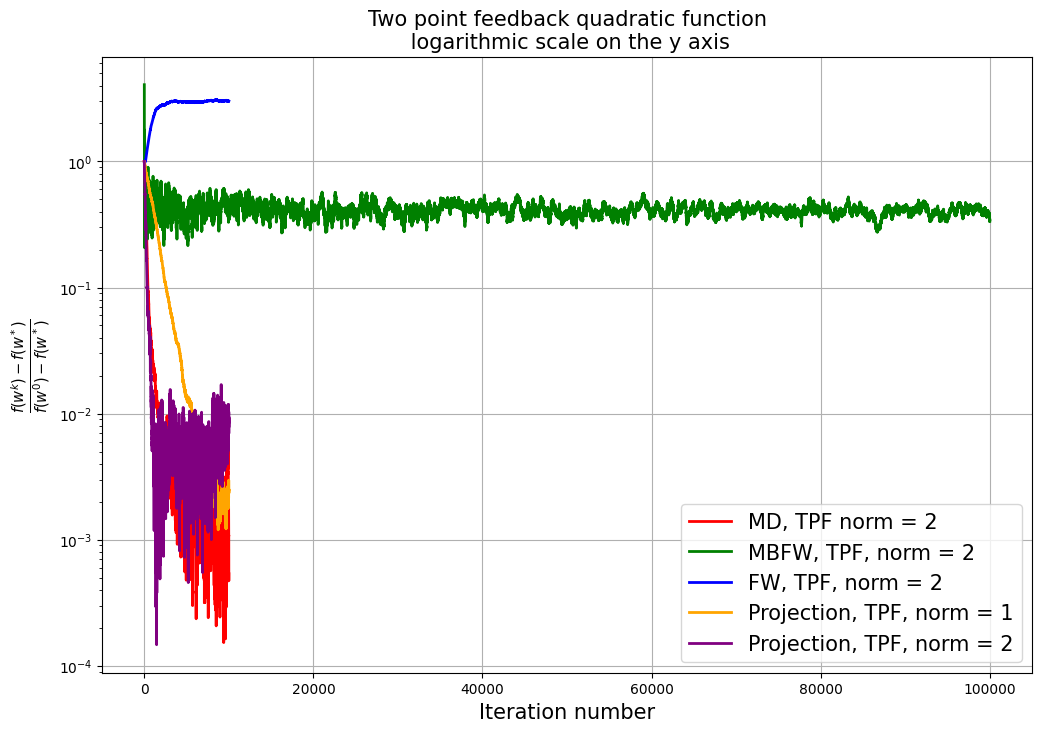

In [66]:
title = "Two point feedback quadratic function"
iterations_tpf = iterations_mir_tpf + iterations_mbfw_tpf + iterations_fw_tpf + iterations_pr_tpf
errors_tpf = errors_mir_tpf + errors_mbfw_tpf + errors_fw_tpf + errors_pr_tpf
labels_tpf = labels_mir_tpf + labels_mbfw_tpf + labels_fw_tpf + labels_pr_tpf
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'
optimizers.make_err_plot(errors_tpf, iterations_tpf, y_label=y_label,
                     labels=labels_tpf, title=title, markers=[None]*100)

# ONE POINT FEEDBACK

## Mirror descent

Mirror descent, OPF, norm=1. f(w_sol) = 10.10295                 , w_sol in simplex: False, sum: 1.00000


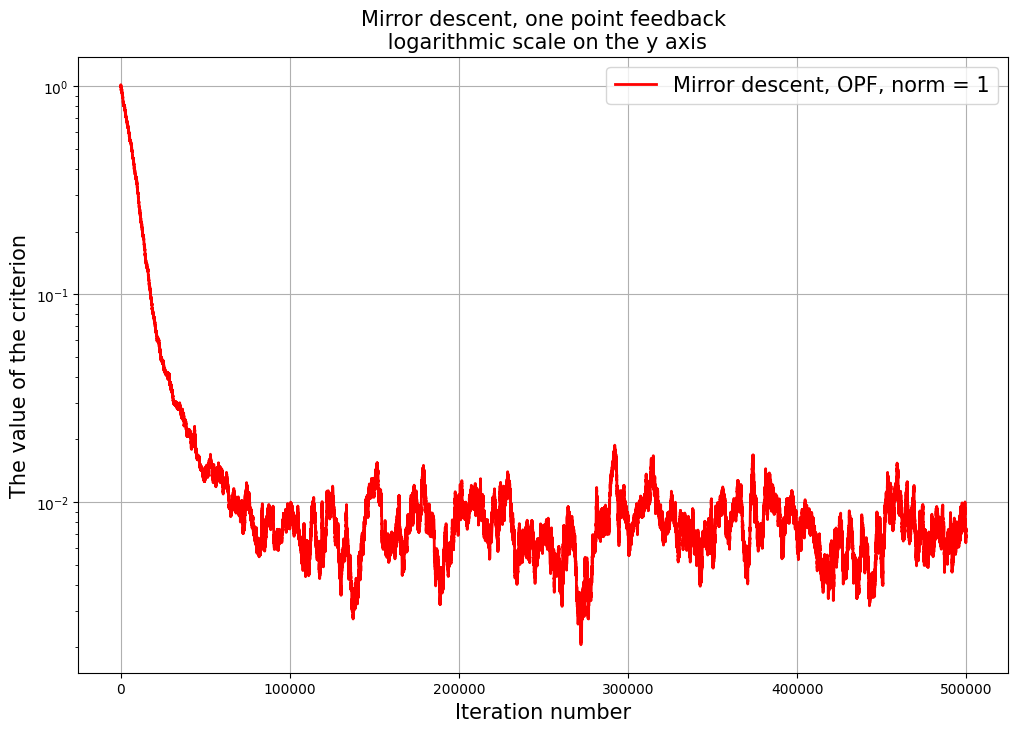

In [74]:
reload(optimizers)

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (50 * args['L'])


title = "Mirror descent, one point feedback"
label = 'Mirror descent, OPF,'

args['gamma'] = lambda k: 1e-1
args['max_steps'] = 10 ** 5
args['criterium'] = 'f(x_k) - f(x^*)'

args['batch_size'] = 1
args['momentum_k'] = momentum_k
args['proj'] = False
args['norms'] = [1]

optimizer = optimizers.MDOptimizer(f, optimizers.get_grad_opf_v3, x_0 = w_0, step = const_gamma, args = args)

iterations_mir_opf, errors_mir_opf, labels_mir_opf, _ = graph(args, optimizer, R_0, label, title)

## Momentum based FW

MBFW, OPF, norm=1. f(w_sol) = 32.89626                 , w_sol in simplex: True, sum: 1.00000


MBFW, OPF, norm=2. f(w_sol) = 38.45214                 , w_sol in simplex: False, sum: 1.00000


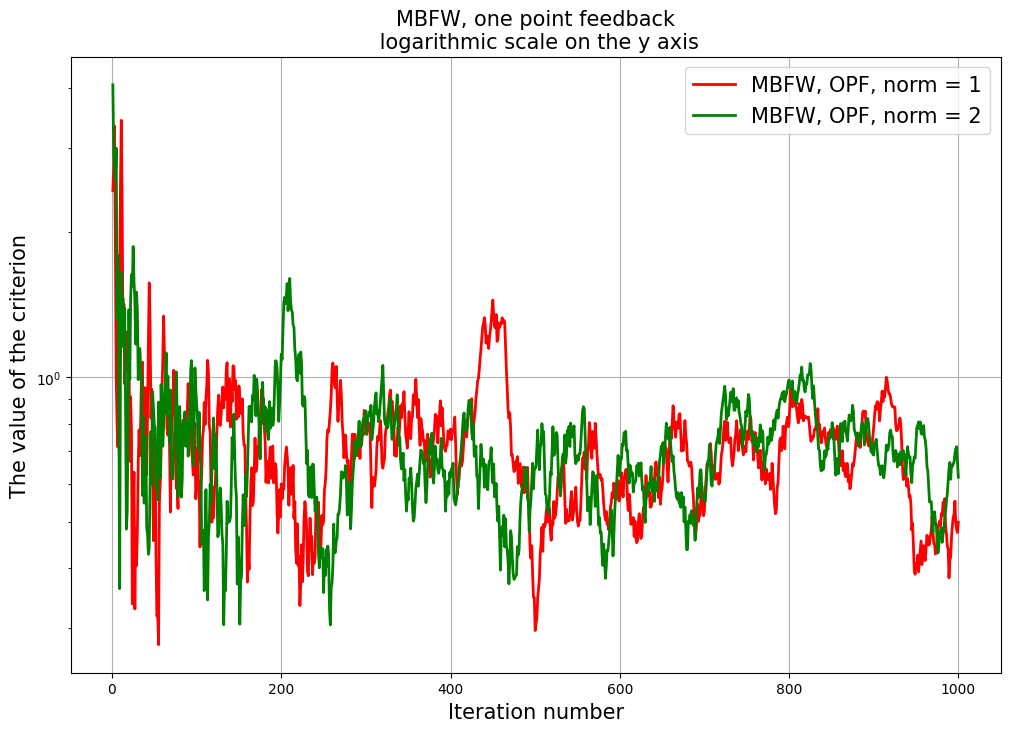

In [15]:
reload(optimizers)

title = "MBFW, one point feedback"
label = 'MBFW, OPF,'

args['gamma'] = lambda k: 1 / np.sqrt(k)
args['max_steps'] = 10 ** 3
args['criterium'] = 'f(x_k) - f(x^*)'

args['batch_size'] = 1
args['momentum_k'] = momentum_k
args['proj'] = False
args['norms'] = [1, 2]

optimizer = optimizers.MBFWOptimizer(f, optimizers.get_grad_opf, x_0 = w_0, step = const_gamma, args = args)

iterations_mbfw_opf, errors_mbfw_opf, labels_mbfw_opf, _ = graph(args, optimizer, R_0, label, title)

## Frank Wolfe

FW, OPF, norm=2. f(w_sol) = 208.77040                 , w_sol in simplex: False, sum: 1.00000


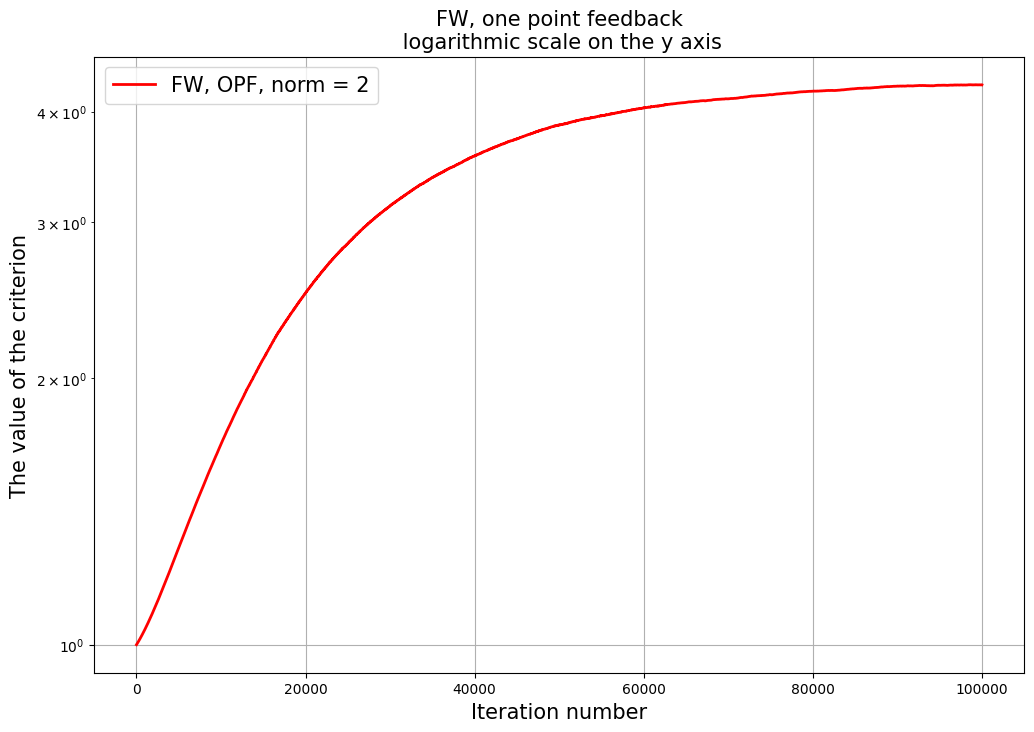

In [94]:
reload(optimizers)

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (20 * args['L'])

title = "FW, one point feedback"
label = 'FW, OPF,'

args['gamma'] = lambda k: 1e-1
args['max_steps'] = 10 ** 5
args['criterium'] = 'f(x_k) - f(x^*)'

args['batch_size'] = 1
args['momentum_k'] = momentum_k
args['proj'] = False
args['norms'] = [2]

optimizer = optimizers.FWOptimizer(f, optimizers.get_grad_opf_v3, x_0 = w_0, step = const_gamma, args = args)

iterations_fw_opf, errors_fw_opf, labels_fw_opf, _ = graph(args, optimizer, R_0, label, title)

## Projection

Proj, OPF, norm=2. f(w_sol) = 10.29506                 , w_sol in simplex: False, sum: 1.00000


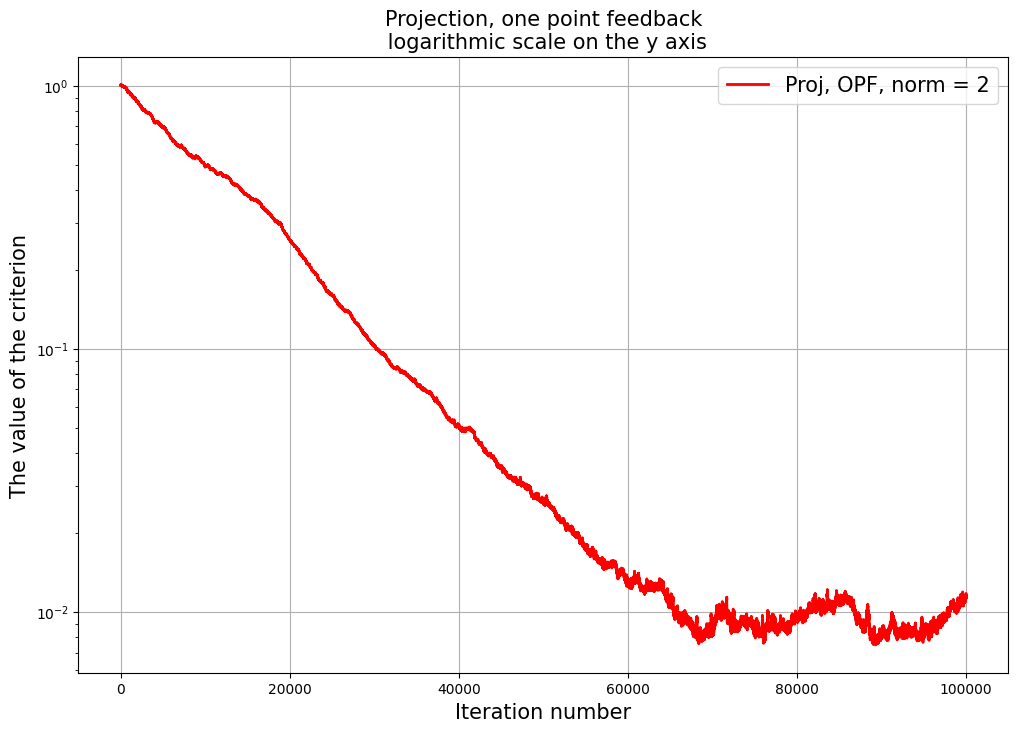

In [89]:
reload(optimizers)

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (1000 * args['L'])


title = "Projection, one point feedback"
label = 'Proj, OPF,'

args['gamma'] = lambda k: 1e-1
args['max_steps'] = 10 * 10 ** 4
args['criterium'] = 'f(x_k) - f(x^*)'

args['batch_size'] = 1
args['momentum_k'] = momentum_k
args['proj'] = True
args['norms'] = [2]

optimizer = optimizers.GDOptimizer(f, optimizers.get_grad_opf_v3, x_0 = w_0, step = const_gamma, args = args)

iterations_pr_opf, errors_pr_opf, labels_pr_opf, _ = graph(args, optimizer, R_0, label, title)

## Results

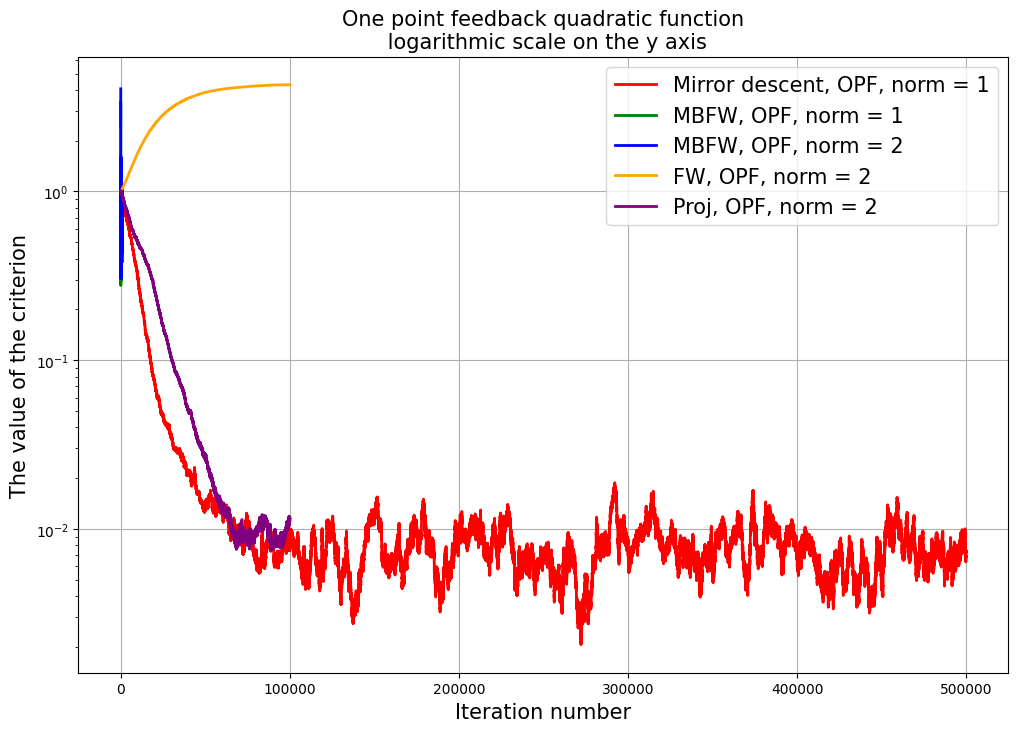

In [95]:
reload(optimizers)

title = "One point feedback quadratic function"
iterations_opf = iterations_mir_opf + iterations_mbfw_opf + iterations_fw_opf + iterations_pr_opf
errors_opf = errors_mir_opf + errors_mbfw_opf + errors_fw_opf + errors_pr_opf
labels_opf = labels_mir_opf + labels_mbfw_opf + labels_fw_opf + labels_pr_opf
optimizers.make_err_plot(errors_opf, iterations_opf,
                     labels=labels_opf, title=title, markers=[None]*100)